<hr/>


# Machine learning models

Indicators which are used for training models are analyzed in indicators notebook

<hr/>


### Imports

In [1]:
import matplotlib
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
import numpy as np
import yfinance as yf
from talib.abstract import *
from datetime import datetime
from math import isclose

# Parameters

In [2]:
fetch_from_yahoo = False

# 'AAPL', 'TSLA', 'AMD', 'NVDA', 'BTC-USD', 'LINK-USD', 'ADA-USD'
ticker = 'BTC' 

# Indicator timeperiod
timeperiod=200

# Aggregate minute data into n data
# '30T' for 30 min candles, '1h' for 1 hour candles...
aggregate='30T'

# Classification percentage treshold
# This parameter affects stoploss for trading, stoploss = treshold / 3
treshold = 0.01

# Split data into train/test
train_size = 0.8
test_size = 0.2

<hr/>

# Data reading

<hr/>

### Fetching daily candles from yahoo finance or minute candles from local folder

In [3]:
if fetch_from_yahoo:
    dt_start = dt.datetime(1990, 1, 1)
    dt_end = dt.datetime.now()

    df = yf.download(ticker, start=dt_start, end=dt_end, group_by="ticker") 
    df.drop(['Adj Close'], axis=1, inplace=True)
    df.columns = ['open', 'high', 'low', 'close', 'volume']

else:
    df = pd.read_csv(f'..\\data\\{ticker}_1m.csv', index_col='date')
    df.index = pd.to_datetime(df.index)
    
    ohlc_dict = {
        'open': 'first',                                                                                                    
        'close': 'last',                                                                                                       
        'high': 'max',                                                                                                        
        'low': 'min',                                                                                                    
        'volume': 'sum',
    }

    df = df.resample(aggregate, closed='left', label='left').apply(ohlc_dict).dropna()
    
df 

open     close      high       low     volume
date                                                                  
2019-09-09 02:30:00  10316.62  10296.04  10316.65  10294.29   96.46200
2019-09-09 03:00:00  10295.81  10314.22  10316.68  10294.50  342.85500
2019-09-09 03:30:00  10314.22  10297.89  10316.30  10267.37  340.13200
2019-09-09 04:00:00  10297.89  10265.41  10300.32  10251.51  340.00500
2019-09-09 04:30:00  10265.41  10316.30  10316.33  10264.54  340.27300
...                       ...       ...       ...       ...        ...
2022-01-17 00:00:00  43071.66  42983.77  43176.18  42920.72  425.71859
2022-01-17 00:30:00  42983.78  42891.12  43051.67  42871.65  307.16742
2022-01-17 01:00:00  42891.11  42895.12  42946.93  42814.78  415.45161
2022-01-17 01:30:00  42895.11  42894.05  42916.88  42810.00  372.36930
2022-01-17 02:00:00  42894.05  42930.26  42936.56  42875.05   52.87542

[41152 rows x 5 columns]

### Converting data to dictionary for ta-lib

In [4]:
data = {
    'open': df['open'].values.astype('float64'),
    'high': df['high'].values.astype('float64'),
    'low': df['low'].values.astype('float64'),
    'close': df['close'].values.astype('float64'),
    'volume': df['volume'].values.astype('float64')
}

In [5]:
data

{'open': array([10316.62, 10295.81, 10314.22, ..., 42891.11, 42895.11, 42894.05]),
 'high': array([10316.65, 10316.68, 10316.3 , ..., 42946.93, 42916.88, 42936.56]),
 'low': array([10294.29, 10294.5 , 10267.37, ..., 42814.78, 42810.  , 42875.05]),
 'close': array([10296.04, 10314.22, 10297.89, ..., 42895.12, 42894.05, 42930.26]),
 'volume': array([ 96.462  , 342.855  , 340.132  , ..., 415.45161, 372.3693 ,
         52.87542])}

<hr/>

# Utility functions

<hr/>

### Extract indicator info

In [6]:
def name(function):
    try:
        return function.__name__
    except:
        return str(function).split('(')[0].strip()

def full_name(function):
    val = str(function).split('(')
    return val[1].split('\n')[-1].strip()

print(name(SMA), full_name(SMA))

SMA Simple Moving Average


### Display class balance

In [7]:
def display_class_balance(y):
    classifications, occurances = np.unique(y, return_counts=True)
    
    for i, classification in enumerate(classifications):
        print(f"Class {classification:2d} occured {occurances[i]:8d} times. This class makes {occurances[i]/len(y) * 100:2.2f}% of all labels")

### Checking the percentage of correct predictions for wanted classes

In [8]:
def score_performance(y_test, prediction, classes=[-1, 1]):
    correct = 0
    all = 0
    for i in range(len(y_test)):
        if y_test[i] in classes:
            all += 1
            if y_test[i] == prediction[i]:
                correct += 1

    return correct / all

score_performance([1, 0, 0, -1, 1], [-1, -1, 0, -1, 1])

0.6666666666666666

<hr/>


# Creating indicators

<hr/>


### Moving averages

In [9]:
ma_types = [SMA, EMA, WMA]

for ma_type in ma_types:
    df[name(ma_type)] = ma_type(data, timeperiod=timeperiod)

### Bolinger bands

In [10]:
indicator = BBANDS

df[f'{name(indicator)}_upper'], df[f'{name(indicator)}_middle'], df[f'{name(indicator)}_lower'] = indicator(data
, timeperiod=timeperiod, nbdevup=2., nbdevdn=2.)

### Kaufman Adaptive Moving Average

In [11]:
indicator = KAMA

df[name(indicator)] = indicator(data)

### Absolute Price Oscillator

In [12]:
indicator = APO

df[name(indicator)] = indicator(data)

### Commodity Channel Index

In [13]:
indicator = CCI

df[name(indicator)] = indicator(data, timeperiod=timeperiod)

### Money Flow Index

In [14]:
indicator = MFI

df[name(indicator)] = indicator(data, timeperiod=timeperiod)

### Momentum

In [15]:
indicator = MOM

df[name(indicator)] = indicator(data, timeperiod=timeperiod)

### Rate of change

In [16]:
indicator = ROC

df[name(indicator)] = indicator(data, timeperiod=timeperiod)

### Relative Strength Index

In [17]:
indicator = RSI

df[name(indicator)] = indicator(data, timeperiod=timeperiod)

### Williams' %R

In [18]:
indicator = WILLR

df[name(indicator)] = indicator(data, timeperiod=timeperiod)

### Beta

In [19]:
indicator = BETA

df[name(indicator)] = indicator(data, timeperiod=timeperiod)

### Pearson's Correlation Coefficient (r)

In [20]:
indicator = CORREL

df[name(indicator)] = indicator(data, timeperiod=timeperiod)

### Linear Regression Angle

In [21]:
indicator = LINEARREG_ANGLE 

df[name(indicator)] = indicator(data, timeperiod=timeperiod)

### Hilbert Transform - Dominant Cycle Phase

In [22]:
indicator = HT_DCPHASE 

df[name(indicator)] = indicator(data)

<hr/>

# Data processing

<hr/>

### Dropping nan rows

In [23]:
df.dropna(inplace=True)

df

open     close      high       low     volume  \
date                                                                     
2019-09-13 06:30:00  10304.37  10295.54  10312.36  10287.61  423.19000   
2019-09-13 07:00:00  10295.54  10288.63  10296.46  10267.89  485.94300   
2019-09-13 07:30:00  10290.67  10284.03  10291.70  10271.54  404.97800   
2019-09-13 08:00:00  10283.68  10307.00  10327.14  10282.00  350.42400   
2019-09-13 08:30:00  10307.00  10278.48  10307.86  10255.25  322.88600   
...                       ...       ...       ...       ...        ...   
2022-01-17 00:00:00  43071.66  42983.77  43176.18  42920.72  425.71859   
2022-01-17 00:30:00  42983.78  42891.12  43051.67  42871.65  307.16742   
2022-01-17 01:00:00  42891.11  42895.12  42946.93  42814.78  415.45161   
2022-01-17 01:30:00  42895.11  42894.05  42916.88  42810.00  372.36930   
2022-01-17 02:00:00  42894.05  42930.26  42936.56  42875.05   52.87542   

                             SMA           EMA           WMA  BBANDS_upper  \
date                                                                         
2019-09-13 06:30:00  10207.24915  10208.130141  10199.976533  10440.721830   
2019-09-13 07:00:00  10207.12120  10208.931135  10200.786293  10440.387204   
2019-09-13 07:30:00  10207.05190  10209.678387  10201.551555  10440.218212   
2019-09-13 08:00:00  10207.25985  10210.646761  10202.546063  10440.707993   
2019-09-13 08:30:00  10207.07075  10211.321719  10203.254721  10440.226370   
...                          ...           ...           ...           ...   
2022-01-17 00:00:00  43113.50555  43006.040026  43050.124926  43957.959451   
2022-01-17 00:30:00  43108.86530  43004.896543  43047.912135  43947.939864   
2022-01-17 01:00:00  43102.86115  43003.804239  43045.785316  43930.707115   
2022-01-17 01:30:00  43098.46595  43002.712157  43043.707593  43921.350862   
2022-01-17 02:00:00  43093.74995  43001.991240  43042.033902  43909.595624   

                     BBANDS_middle  ...        CCI        MFI      MOM  \
date                                ...                                  
2019-09-13 06:30:00    10207.24915  ...  58.711166  47.284496    -0.50   
2019-09-13 07:00:00    10207.12120  ...  49.645838  46.538263   -25.59   
2019-09-13 07:30:00    10207.05190  ...  48.471817  46.483855   -13.86   
2019-09-13 08:00:00    10207.25985  ...  63.188662  47.110904    41.59   
2019-09-13 08:30:00    10207.07075  ...  47.163646  46.508137   -37.82   
...                            ...  ...        ...        ...      ...   
2022-01-17 00:00:00    43113.50555  ... -18.418265  48.480283  -713.73   
2022-01-17 00:30:00    43108.86530  ... -36.514240  47.968404  -928.05   
2022-01-17 01:00:00    43102.86115  ... -47.083409  47.301314 -1200.83   
2022-01-17 01:30:00    43098.46595  ... -49.130847  47.460960  -879.04   
2022-01-17 02:00:00    43093.74995  ... -39.800792  47.618086  -943.20   

                          ROC        RSI      WILLR      BETA    CORREL  \
date                                                                      
2019-09-13 06:30:00 -0.004856  49.994893 -30.445004  0.254062  0.958771   
2019-09-13 07:00:00 -0.248104  49.924068 -31.613754  0.255009  0.958767   
2019-09-13 07:30:00 -0.134591  49.876794 -32.391793  0.254888  0.958584   
2019-09-13 08:00:00  0.405147  50.113859 -28.506673  0.254338  0.958651   
2019-09-13 08:30:00 -0.366604  49.819826 -33.330514  0.255411  0.958630   
...                       ...        ...        ...       ...       ...   
2022-01-17 00:00:00 -1.633343  49.685720 -54.657631  0.506045  0.953489   
2022-01-17 00:30:00 -2.117909  49.480747 -57.997513  0.514007  0.953203   
2022-01-17 01:00:00 -2.723221  49.489789 -57.853319  0.514285  0.953505   
2022-01-17 01:30:00 -2.008174  49.487408 -57.891891  0.517295  0.952920   
2022-01-17 02:00:00 -2.149819  49.569930 -56.586579  0.523537  0.951901   

                     LINEARREG_ANGLE  HT_DCPHASE  
date                                              
2019-0

### Creating data labels

In [24]:
# x1 is value preceding x2
def compare(x1, x2, rel_tol):
    if isclose(x1, x2, rel_tol=rel_tol):
        return 0
    if x1 > x2:
        return -1
    return 1
    
print(compare(100, 99.94, 0.0005), compare(100, 99.96, 0.001))    

-1 0


#### TODO: Možda bi trebao izračunati povijesnu volatilnost asseta i prema njoj odrediti treshold tipa treshold = volatilnost/3

#### TODO: Možda bih trebao gledati volatilnost ili relativni porast (u postotku u odnosu na high/low od podataka) i prema toj vrijednosti računati klase porast/pad

In [25]:
def create_classification(close_arr):
    classification = []
    for i in range(len(close_arr) - 1):
        classification.append(compare(close_arr[i], close_arr[i + 1], treshold))
        
    return np.array(classification)

In [26]:
y = create_classification(df['close'])

y.shape

(40951,)

### Data scaling

https://www.geeksforgeeks.org/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/

In [27]:
from sklearn.preprocessing import StandardScaler

cols = ['open', 'high', 'low', 'close', 'SMA', 'EMA', 'WMA', 'BBANDS_upper', 'BBANDS_middle', 'BBANDS_lower', 'KAMA']
scaler = StandardScaler()

def scale(df):
    scaled_df = df.copy()
    scaled_df[cols] = df[cols].div(df['open'], axis=0)
    return pd.DataFrame(scaler.fit_transform(scaled_df.values), columns=scaled_df.columns, index=scaled_df.index)

In [28]:
x = scale(df)[:-1].values

x.shape

(40951, 23)

### Creating data windows (not implemented yet!)

TODO: try out if creating windows that are not dependent on other windows. I.e. create windows from original data and indicator values and scale each window corresponding to the price

### Data splitting

In [29]:
x_train = x[:int(len(x) * train_size)]
x_test = x[-int(len(x) * test_size):]
y_train = y[:int(len(x) * train_size)]
y_test = y[-int(len(x) * test_size):]

In [30]:
print(f"x_train shape: {x_train.shape}; y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}; y_test shape: {y_test.shape}")

x_train shape: (32760, 23); y_train shape: (32760,)
x_test shape: (8190, 23); y_test shape: (8190,)


In [31]:
print("Y train class balance:")
display_class_balance(y_train)

Y train class balance:
Class -1 occured     1109 times. This class makes 3.39% of all labels
Class  0 occured    30537 times. This class makes 93.21% of all labels
Class  1 occured     1114 times. This class makes 3.40% of all labels


In [32]:
print("Y test class balance:")
display_class_balance(y_test)

Y test class balance:
Class -1 occured      179 times. This class makes 2.19% of all labels
Class  0 occured     7813 times. This class makes 95.40% of all labels
Class  1 occured      198 times. This class makes 2.42% of all labels


<hr/>

# Model training and evaluating

<hr/>

In [33]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=10000, class_weight='balanced', penalty="none").fit(x_train, y_train) 

#### TODO: Implement a loss function that punishes false signals way harder than not making signals even though there was a signal

In [34]:
print(f"Model achieved accuracy of {model.score(x_test, y_test) * 100:3.2f}%")

Model achieved accuracy of 81.31%


In [35]:
prediction = model.predict(x_test)

In [36]:
display_class_balance(prediction)

Class -1 occured      738 times. This class makes 9.01% of all labels
Class  0 occured     6816 times. This class makes 83.22% of all labels
Class  1 occured      636 times. This class makes 7.77% of all labels


### Checking the percentage of correct predictions for wanted classes

In [37]:
print(f"Model achieved accuracy of {score_performance(y_test, prediction, [0]) * 100:3.2f}% on class 0")

Model achieved accuracy of 84.23% on class 0


In [38]:
print(f"Model achieved accuracy of {score_performance(y_test, prediction, [1]) * 100:3.2f}% on class 1")

Model achieved accuracy of 16.16% on class 1


In [39]:
print(f"Model achieved accuracy of {score_performance(y_test, prediction, [-1]) * 100:3.2f}% on class -1")

Model achieved accuracy of 25.70% on class -1


In [40]:
for k, coefficients in enumerate(model.coef_):
    print(f"\nCoefficients {k}:")
    for i, col in enumerate(df.columns):
        print(f"Column {col:20s} has a weight of {coefficients[i]:8.4f}")


Coefficients 0:
Column open                 has a weight of   0.0000
Column close                has a weight of  -0.0295
Column high                 has a weight of   0.1988
Column low                  has a weight of  -0.1834
Column volume               has a weight of   0.0073
Column SMA                  has a weight of   0.0065
Column EMA                  has a weight of   0.5078
Column WMA                  has a weight of  -0.4289
Column BBANDS_upper         has a weight of   0.1058
Column BBANDS_middle        has a weight of   0.0065
Column BBANDS_lower         has a weight of  -0.1233
Column KAMA                 has a weight of  -0.0171
Column APO                  has a weight of  -0.0168
Column CCI                  has a weight of  -0.1682
Column MFI                  has a weight of  -0.0826
Column MOM                  has a weight of   0.0394
Column ROC                  has a weight of   0.2066
Column RSI                  has a weight of   0.0845
Column WILLR                h

### Graph overlay with predictions

In [41]:
test_df = df[['open', 'high', 'low', 'close']][-(len(prediction) + 1):-1]
test_df['prediction'] = prediction
test_df['real'] = y_test

### Calculating returns over test period

In [42]:
trades = pd.DataFrame()

for i in range(len(test_df) - 1):
    row = test_df.iloc[i]
    if row['prediction'] == 1:
        next_row = test_df.iloc[i + 1]
        stoploss = row['close'] * (1 - treshold / 4)
        
        if next_row['low'] < stoploss:
            roi = (1 - treshold / 4)
            trades = trades.append({'date':row.name, 'entry':row['close'], 'exit':stoploss, 'type':'long', 'roi':roi, 'stoploss':"yes"}, ignore_index=True)
        else:
            roi = next_row['close'] / row['close']
            trades = trades.append({'date':row.name, 'entry':row['close'], 'exit':next_row['close'], 'type':'long', 'roi':roi}, ignore_index=True)
        
    elif row['prediction'] == -1:
        next_row = test_df.iloc[i + 1]
        stoploss = row['close'] * (1 + treshold / 4)
        
        if next_row['high'] > stoploss:
            roi = (1 - treshold / 4)
            trades = trades.append({'date':row.name, 'entry':row['close'], 'exit':stoploss, 'type':'short', 'roi':roi, 'stoploss':"yes"}, ignore_index=True)
        else:
            roi = row['close'] / next_row['close']
            trades = trades.append({'date':row.name, 'entry':row['close'], 'exit':next_row['close'], 'type':'short', 'roi':roi}, ignore_index=True)
        
print(f"Model achieved increase of {trades['roi'].prod():6.4f} times trading from {test_df.iloc[0].name} to {test_df.iloc[-1].name}")

trades.set_index('date', inplace=True)
trades.sort_values(by=['roi'])

Model achieved increase of 0.7392 times trading from 2021-07-30 04:30:00 to 2022-01-17 01:30:00


entry          exit   type       roi stoploss
date                                                                 
2021-07-30 08:30:00  38723.01  38626.202475   long  0.997500      yes
2021-10-27 19:30:00  59062.32  59209.975800  short  0.997500      yes
2021-10-27 20:00:00  58796.58  58943.571450  short  0.997500      yes
2021-10-28 01:00:00  58686.42  58833.136050  short  0.997500      yes
2021-10-28 08:30:00  60560.38  60711.780950  short  0.997500      yes
...                       ...           ...    ...       ...      ...
2021-09-08 08:00:00  45051.86  45983.620000   long  1.020682      NaN
2021-12-06 11:00:00  47454.61  48577.780000   long  1.023668      NaN
2021-11-30 15:00:00  59065.17  57238.840000  short  1.031907      NaN
2021-09-24 08:30:00  44517.29  42776.270000  short  1.040701      NaN
2021-09-20 23:30:00  43015.62  41082.360000  short  1.047058      NaN

[1374 rows x 5 columns]

In [43]:
print(f"Winning trades: {len(trades[trades['roi'] > 1])}, losing trades: {len(trades[trades['roi'] < 1])}")

Winning trades: 401, losing trades: 973


### Graph overlay with predictions

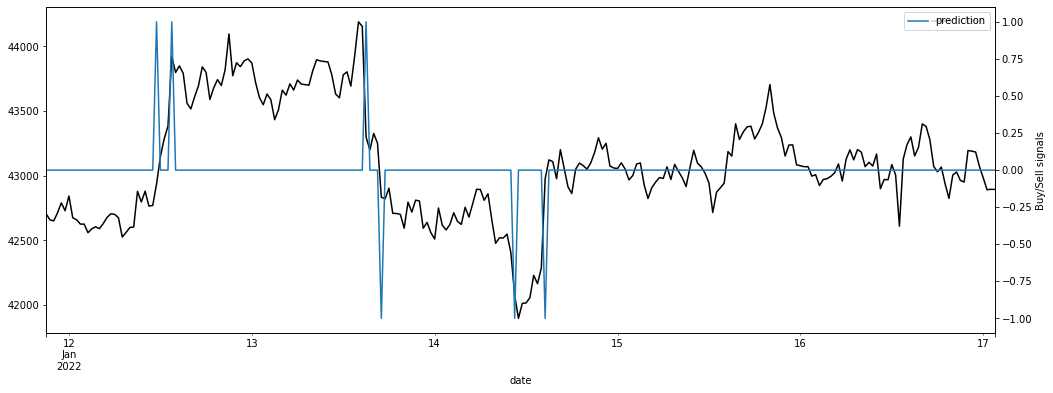

In [44]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

test_df[['close']][-250:].plot(figsize=(17,6), ax=ax1, color='k')
test_df[['prediction']][-250:].plot(figsize=(17,6), ax=ax2, ylabel="Buy/Sell signals")

plt.show()

In [45]:
test_df.tail(n=50)

open      high       low     close  prediction  real
date                                                                         
2022-01-16 01:00:00  43069.69  43153.63  42985.81  43070.01           0     0
2022-01-16 01:30:00  43070.01  43080.18  42991.09  42996.99           0     0
2022-01-16 02:00:00  42996.99  43075.71  42981.00  43007.82           0     0
2022-01-16 02:30:00  43009.34  43087.18  42838.00  42923.66           0     0
2022-01-16 03:00:00  42922.93  43004.16  42861.49  42970.48           0     0
2022-01-16 03:30:00  42970.48  43046.84  42892.61  42977.22           0     0
2022-01-16 04:00:00  42977.22  43089.00  42850.16  42994.73           0     0
2022-01-16 04:30:00  42994.73  43067.01  42980.74  43023.02           0     0
2022-01-16 05:00:00  43023.57  43123.43  43010.53  43091.10           0     0
2022-01-16 05:30:00  43091.10  43106.39  42953.17  42958.69           0     0
2022-01-16 06:00:00  42953.17  43131.75  42925.88  43126.99           0     0
2022-01-16 06:30:00  43126.98  43225.86  43080.00  43200.00           0     0
2022-01-16 07:00:00  43200.00  43253.68  43122.68  43122.69           0     0
2022-01-16 07:30:00  43122.69  43252.06  43117.24  43202.21           0     0
2022-01-16 08:00:00  43202.21  43305.00  43165.64  43182.27           0     0
2022-01-16 08:30:00  43182.26  43215.94  43059.99  43070.27           0     0
2022-01-16 09:00:00  43070.26  43128.09  43028.02  43104.01           0     0
2022-01-16 09:30:00  43104.01  43131.37  43047.26  43074.99           0     0
2022-01-16 10:00:00  43074.99  43185.71  43073.05  43168.03           0     0
2022-01-16 10:30:00  43168.03  43177.74  42868.31  42899.99           0     0
2022-01-16 11:00:00  42900.00  42990.14  42759.00  42970.84           0     0
2022-01-16 11:30:00  42970.84  43042.67  42858.10  42968.29           0     0
2022-01-16 12:00:00  42968.30  43141.55  42954.16  43085.95           0     0
2022-01-16 12:30:00  43085.91  43140.00  42978.00  43005.93           0     0
2022-01-16 13:00:00  43005.93  43026.08  42581.79  42610.13           0     1
2022-01-16 13:30:00  42610.14  43187.87  42590.14  43129.54           0     0
2022-01-16 14:00:00  43129.54  43380.00  43026.70  43241.02           0     0
2022-01-16 14:30:00  43241.03  43416.05  43210.17  43300.02           0     0
2022-01-16 15:00:00  43300.01  43317.52  43150.00  43152.99           0     0
2022-01-16 15:30:00  43153.00  43350.00  43139.24  43219.53           0     0
2022-01-16 16:00:00  43219.54  43475.00  43172.01  43400.80           0     0
2022-01-16 16:30:00  43400.80  43457.21  43299.31  43381.45           0     0
2022-01-16 17:00:00  43381.46  43428.83  43276.57  43276.84           0     0
2022-01-16 17:30:00  43280.01  43304.38  43051.08  43071.88           0     0
2022-01-16 18:00:00  43071.88  43126.04  42999.50  43031.00           0     0
2022-01-16 18:30:00  43030.99  43095.87  42969.32  43066.80           0     0
2022-01-16 19:00:00  43066.79  43081.28  42895.78  42936.40           0     0
2022-01-16 19:30:00  42936.40  42957.15  42790.02  42824.79           0     0
2022-01-16 20:00:00  42824.79  43053.82  42750.25  43005.33           0     0
2022-01-16 20:30:00  43005.33  43117.05  42940.50  43029.01           0     0
2022-01-16 21:00:00  43029.06  43093.01  42933.37  42963.64           0     0
2022-01-16 21:30:00  42963.64  43018.31  42900.70  42951.01           0     0
2022-01-16 22:00:00  42951.02  43199.98  42940.00  43194.99           0     0
2022-01-16 22:30:00  43195.00  43245.00  43099.99  43190.01           0     0
2022-01-16 23:00:00  43190.00  43263.15  43111.11  43183.11           0     0
2022-01-16 23:30:00  43183.11  43228.69  43048.20  43071.66           0     0
2022-01-17 00:00:00  43071.66  43176.18  42920.72  42983.77           0     0
2022-01-17 00:30:00  42983.78  43051.67  42871.65  42891.12           0     0
2022-01-17 01:00:00  42891.11  42946.93  42814.78  42895.12           0     0
2022-01-17 01:30:00  42895.11  42916.88  42810.